In [1]:
# Install MySql packages
# conda update -n base -c conda-forge conda --yes
# !pip install ipython-sql
# !pip install mysql-connector-python
# !conda install -c conda-forge python-dotenv --yes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import mysql.connector
from mysql.connector import Error
from os import environ, path
from dotenv import load_dotenv
from pandas.api.types import CategoricalDtype

In [3]:
# Read enviromental variables to connect the database
load_dotenv()
password = environ.get('PASSWORD')
host = environ.get('HOST')
database = environ.get('DATABASE')

In [45]:
# List of colors
colors = ['lime', 'darkorange', 'darkgreen', 'royalblue', 
         'darkred', 'gold', 'teal', 'blueviolet', 'coral', 
         'yellowgreen', 'steelblue', 'crimson', 'tan']

## Connect to the database and create dataframes for each table

In [4]:
try:
    connection = mysql.connector.connect(host=host ,
                                        database=database,
                                        user='root',
                                        password=password)
    if connection.is_connected():
        print("Succes Connected")
    df_musician = pd.read_sql_query("SELECT * FROM music_and_death.musician;", connection)
    df_birth = pd.read_sql_query("SELECT * FROM music_and_death.birth;", connection)
    df_death = pd.read_sql_query("SELECT * FROM music_and_death.death;", connection)
    df_genre = pd.read_sql_query("SELECT * FROM music_and_death.music_genre;", connection)
    genre = pd.read_sql_query("SELECT * FROM music_and_death.genre;", connection)
    cause_death = pd.read_sql_query("SELECT * FROM music_and_death.cause_death;", connection)
    cities = pd.read_sql_query("SELECT * FROM music_and_death.cities;", connection)
    states = pd.read_sql_query("SELECT * FROM music_and_death.states;", connection)
    countries = pd.read_sql_query("SELECT * FROM music_and_death.countries;", connection)
    
    
except Error as e:
    print("Error closing connection")

# Concatenate tables
else:
    # Concatenate musician and death dataframes
    df = pd.concat([df_musician, df_birth], axis=1)
    df = pd.concat([df, df_death], axis=1)
    df = pd.merge(df, cause_death, on=["death_id", "death_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, df_genre, on=["musician_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, genre, on=["genre_id"])
    # rearrange columns
    df = df.iloc[:, [0, 1, 2, 3, 5, 7, 8, 9, 11, 6, 4, 10]]
    
finally:
    connection.close()

Succes Connected


/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/home/ivan/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordat

## Merge and clean the cities, states and countries tables

In [5]:
# merge cities table with states table
place = cities.merge(states, 
                      left_on=cities["state_id"], 
                      right_on=states["id"])

# drop duplicate keys
place.drop(['key_0', 'state_id', 'id_y'], axis=1, inplace=True)

# merge resulted table with countries table
place = place.merge(countries, 
                        left_on=place["country_id"],
                        right_on=countries["id"])

# drop duplicated keys
place.drop(['key_0', 'country_id', 'id', 'iso2', 'capital'], 
              axis=1, 
              inplace=True)

# rename column names
place.rename(
    columns={'name_x': 'City', 
             'name_y': 'State', 
             'name': 'Country', 
             'id_x': 'city_id'},
    inplace=True
)

##  Drop columns with not use

In [6]:
df.drop(['middle_name', 'death_id', "death_date", "genre_id", "birth"], 
        axis=1, 
        inplace=True)

In [7]:
df

,musician_id,stage_name,stage_lastname,death_age,cause,genre,birthplace_id
0,1,John,Lennon,40,homicide,rock,50337
1,432,Kit,Lambert,45,homicide,rock,50388
2,459,Rusty,Day,36,homicide,rock,117057
3,481,Felix,Pappalardi,43,homicide,rock,122795
4,2,Kurt,Cobain,27,suicide,rock,110979
...,...,...,...,...,...,...,...
519,148,A.,Carter,68,unknown,country,126050
520,380,Sara,Carter,80,unknown,country,125539
521,516,Meredith,Willson,82,heart disease,classical,121375
522,478,William,Walton,80,natural,classical,50807


In [8]:
place

,city_id,City,State,Country
0,52,Ashkāsham,Badakhshan,Afghanistan
1,68,Fayzabad,Badakhshan,Afghanistan
2,78,Jurm,Badakhshan,Afghanistan
3,84,Khandūd,Badakhshan,Afghanistan
4,115,Rāghistān,Badakhshan,Afghanistan
...,...,...,...,...
148261,131496,Redcliff,Midlands Province,Zimbabwe
148262,131502,Shangani,Midlands Province,Zimbabwe
148263,131503,Shurugwi,Midlands Province,Zimbabwe
148264,131504,Shurugwi District,Midlands Province,Zimbabwe


## Merge musician info dataframe with place dataframe

In [9]:
# merge df and place dataframes
musician = df.merge(place, 
                    left_on=df['birthplace_id'], 
                    right_on=place['city_id'])

# drop unused columns
musician.drop(['birthplace_id', 'city_id', 'key_0'], axis=1, inplace=True)

In [10]:
musician

,musician_id,stage_name,stage_lastname,death_age,cause,genre,City,State,Country
0,1,John,Lennon,40,homicide,rock,Liverpool,England,United Kingdom
1,271,Rory,Storm,34,suicide,rock,Liverpool,England,United Kingdom
2,502,Tom,Evans,36,suicide,rock,Liverpool,England,United Kingdom
3,473,Billy,Fury,42,heart disease,rock,Liverpool,England,United Kingdom
4,188,Brian,Epstein,32,drug overdose,rock,Liverpool,England,United Kingdom
...,...,...,...,...,...,...,...,...,...
518,37,Johnny,Cash,71,diabetes,country,Cleveland County,Arkansas,United States
519,380,Sara,Carter,80,unknown,country,Russell County,Virginia,United States
520,516,Meredith,Willson,82,heart disease,classical,Mason City,Iowa,United States
521,478,William,Walton,80,natural,classical,Oldham,England,United Kingdom


## Create plots to observe the data

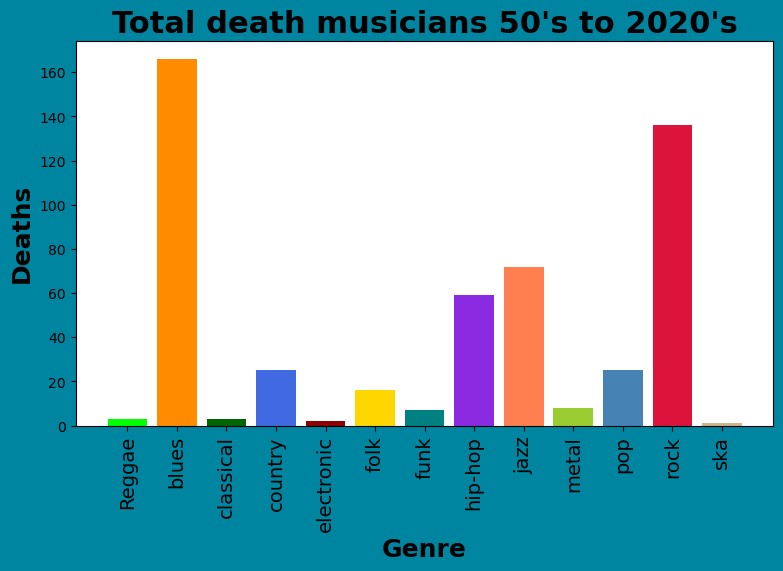

In [46]:
# Bar plot to show deaths per music genre 

# Create a new music table using genre as indez and size of each genre
df_n = musician.pivot_table(index=['genre'], aggfunc='size')

# plot the data
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor("white")
ax.set_title("Total death musicians 50's to 2020's",
             size=22,
             fontweight="bold" )
plt.bar(df_n.index, df_n, color=colors)
plt.ylabel("Deaths", size=18, fontweight="bold")
plt.xlabel("Genre", size=18, fontweight="bold")
plt.xticks(rotation='vertical', size=14)
plt.show()

## Cause of death per music genre

In [12]:
df_cd = musician.pivot_table(index=['cause', 'genre'], aggfunc='size')
df_cd

cause    genre     
AIDS     electronic     1
         pop            1
         rock           2
Burned   blues          1
Falling  rock           1
                       ..
unknown  electronic     1
         folk           2
         jazz          10
         pop            3
         rock           3
Length: 98, dtype: int64

# Questions

## Most common Death Ages


In [13]:
n_da = musician['death_age'].value_counts().nlargest(10)

In [14]:
n_da

27    26
32    24
28    17
37    16
34    15
36    14
25    14
39    14
33    14
24    13
Name: death_age, dtype: int64

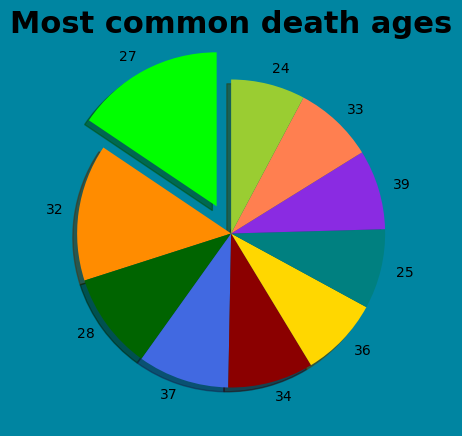

In [47]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Most common death ages",
             size=22,
             fontweight="bold" )
plt.pie(n_da.values, labels=n_da.index, 
        colors=colors,
        startangle=90,
        shadow=True,
        explode = [0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
plt.show()

## Most common Music Genre

In [16]:
n_mg = musician['genre'].value_counts()

In [17]:
n_mg

blues         166
rock          136
jazz           72
hip-hop        59
pop            25
country        25
folk           16
metal           8
funk            7
Reggae          3
classical       3
electronic      2
ska             1
Name: genre, dtype: int64

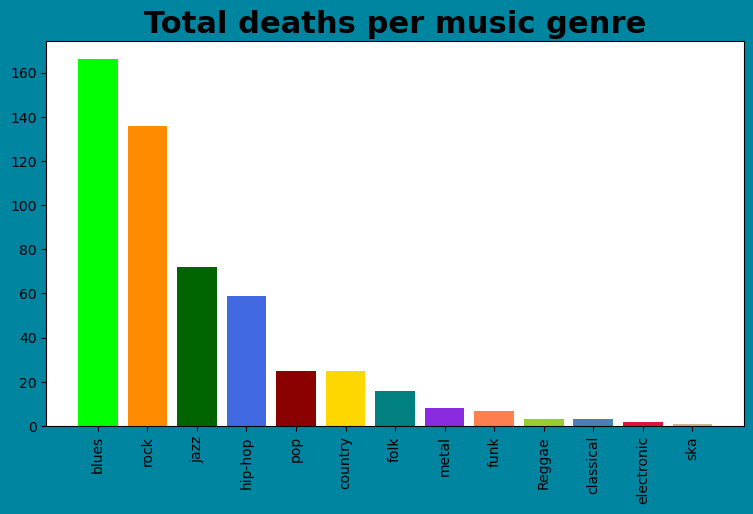

In [52]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Total deaths per music genre",
             size=22,
             fontweight="bold" )
plt.bar(n_mg.index, n_mg.values, color=colors)
plt.xticks(rotation='vertical')
plt.show()

# Places

### Most common Countries

In [19]:
n_places = musician['Country'].value_counts().nlargest(10)

In [20]:
n_places

United States     422
United Kingdom     54
Canada              6
Jamaica             5
Australia           5
Germany             4
Lithuania           2
Spain               2
New Zealand         2
South Africa        2
Name: Country, dtype: int64

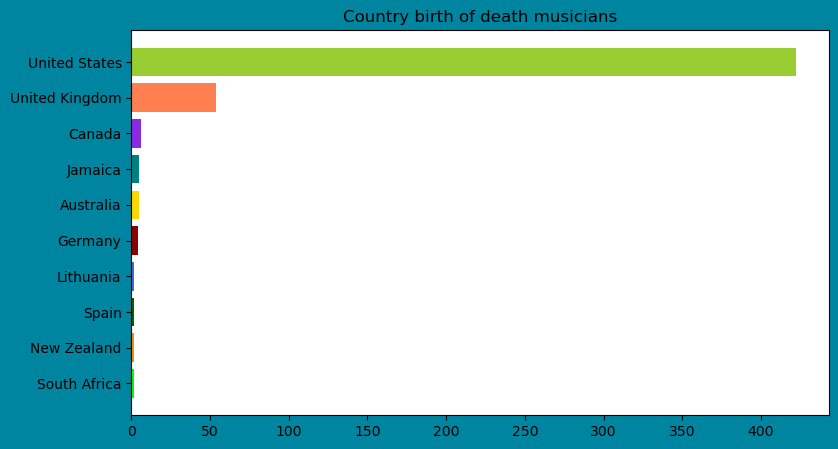

In [54]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
plt.barh(n_places.iloc[::-1].index, n_places.iloc[::-1].values, color=colors)
plt.title("Country birth of death musicians")
plt.show()

### Most common States

In [22]:
n_states = musician['State'].value_counts().nlargest(10)

In [23]:
n_states

Mississippi     46
England         44
New York        43
Texas           36
California      31
Louisiana       27
Tennessee       25
Pennsylvania    18
Alabama         17
Illinois        17
Name: State, dtype: int64

### Most common Cities

In [24]:
n_cities = musician['City'].value_counts().nlargest(10)

In [25]:
n_cities

New York City    25
London           17
Chicago          15
Philadelphia     14
Los Angeles      12
New Orleans      12
Memphis          11
Birmingham       10
Detroit           6
Queens            5
Name: City, dtype: int64

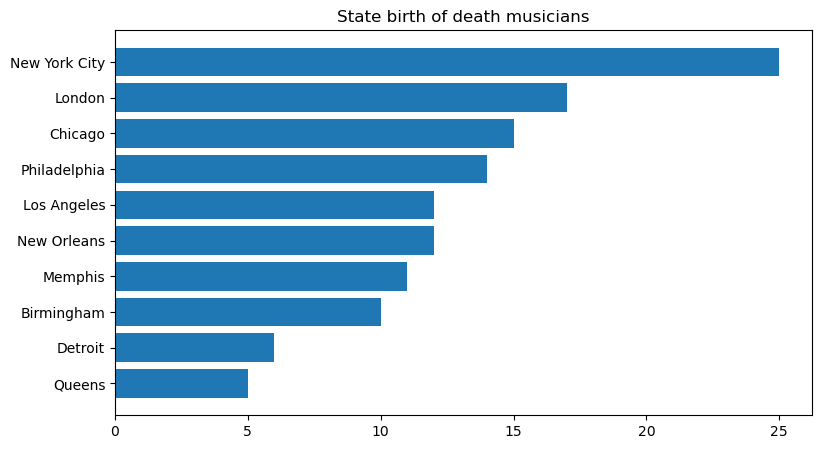

In [26]:
plt.figure(figsize=(9, 5))
plt.barh(n_cities.iloc[::-1].index, n_cities.iloc[::-1].values)
plt.title("State birth of death musicians")
plt.show()

## Death genre - cause

In [27]:
n_cd_gr = musician.loc[:, ['genre', 'cause']].value_counts()

In [28]:
n_cd_gr

genre    cause            
hip-hop  homicide             58
blues    heart disease        48
rock     drug overdose        24
blues    cancer               23
jazz     heart disease        22
                              ..
         suicide               1
         surgery               1
         tuberculosis          1
metal    aircraft accident     1
ska      suicide               1
Length: 98, dtype: int64

In [29]:
n_cd_gr = n_cd_gr.reset_index()
n_cd_gr.rename(columns={0: 'deaths'}, inplace=True)

In [30]:
n_cd_gr

,genre,cause,deaths
0,hip-hop,homicide,58
1,blues,heart disease,48
2,rock,drug overdose,24
3,blues,cancer,23
4,jazz,heart disease,22
...,...,...,...
93,jazz,suicide,1
94,jazz,surgery,1
95,jazz,tuberculosis,1
96,metal,aircraft accident,1


### Blues 

In [31]:
n_blues = n_cd_gr.loc[n_cd_gr['genre'] == 'blues', ]

In [32]:
n_blues

,genre,cause,deaths
1,blues,heart disease,48
3,blues,cancer,23
6,blues,unknown,22
10,blues,homicide,12
13,blues,respiratory disease,11
17,blues,brain related,7
19,blues,alcohol related,6
21,blues,diabetes,6
22,blues,car/motorcycle accident,6
23,blues,drug overdose,6


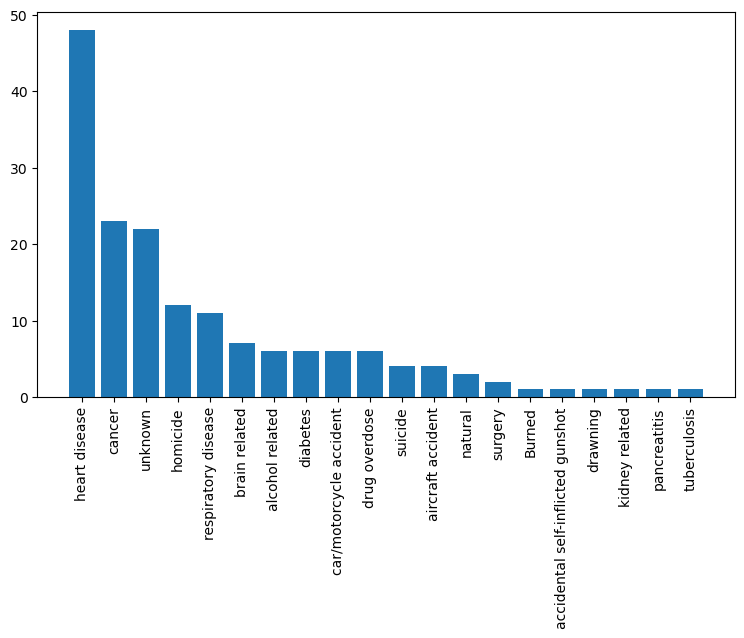

In [33]:
plt.figure(figsize=(9,5))
plt.bar(n_blues['cause'], n_blues['deaths'])
plt.xticks(rotation='vertical')
plt.show()


### Rock

In [34]:
n_rock = n_cd_gr.loc[n_cd_gr['genre'] == 'rock', ]

In [35]:
n_rock

,genre,cause,deaths
2,rock,drug overdose,24
5,rock,heart disease,22
7,rock,suicide,18
8,rock,car/motorcycle accident,16
11,rock,alcohol related,12
12,rock,cancer,11
18,rock,aircraft accident,6
24,rock,drawning,5
26,rock,brain related,5
31,rock,respiratory disease,4


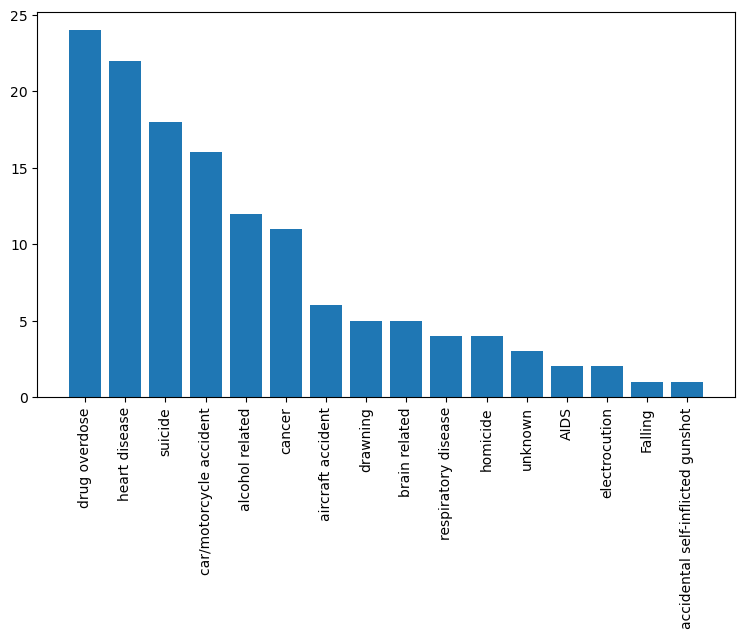

In [36]:
plt.figure(figsize=(9,5))
plt.bar(n_rock['cause'], n_rock['deaths'])
plt.xticks(rotation='vertical')

plt.show()

## Most common Cause o deaths

In [37]:
n_cause_death = musician['cause'].value_counts()

In [38]:
n_cause_death

heart disease                        111
homicide                              82
cancer                                54
drug overdose                         47
unknown                               43
car/motorcycle accident               36
suicide                               28
aircraft accident                     23
respiratory disease                   22
alcohol related                       20
brain related                         19
diabetes                               8
drawning                               7
AIDS                                   4
natural                                4
surgery                                3
accidental self-inflicted gunshot      3
electrocution                          2
tuberculosis                           2
kidney related                         2
Burned                                 1
Falling                                1
pancreatitis                           1
Name: cause, dtype: int64